In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit
import jax.random as random
rng = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)
from scipy.stats import gaussian_kde, gamma, lognorm, entropy
import pandas as pd

from mat_models import MR, mn_sigma_vmap as mn_sigma
from utils_node import init_params, NODE_model
from utils import train_jp, eval_Cauchy
from utils_diffusion import *

/opt/homebrew/lib/python3.9/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(4, 5, 6), but only accepts 6 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


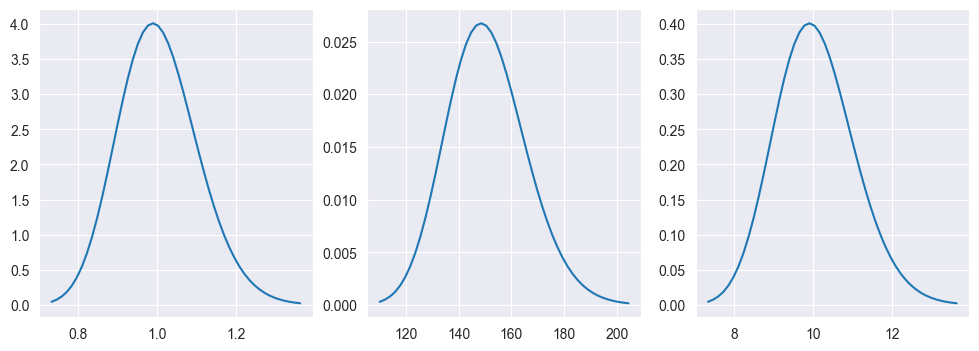

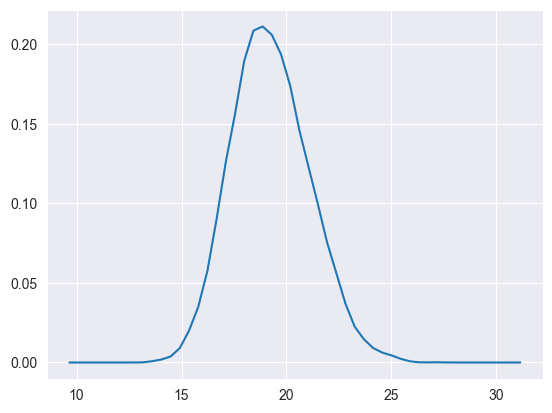

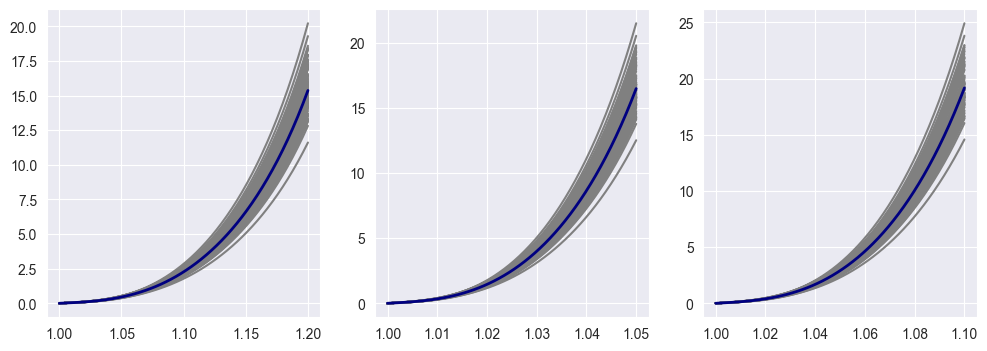

In [2]:
# Generate training data from May-Newmann model
MN_params  = [1.0,         150,         10] # baseline params
J = 10000 # J different samples 
fig, ax = plt.subplots(1,3,figsize=(12,4))
MN_params_s = np.zeros((J,len(MN_params)))
theta = 1.0
for j in range(len(MN_params)):
    p = MN_params[j]
    s = 0.1
    scale = p
    x = np.linspace(lognorm.ppf(0.001, s, scale=scale), 
                    lognorm.ppf(0.999, s, scale=scale))
    y = lognorm.pdf(x, s, scale=scale)
    ax[j].plot(x,y)
    for i in range(J):
        MN_params_s[i,j] = lognorm.rvs(s, scale=p)

# Given thse parameters, generate bunch of curves for different tests
# and plot to see: 3 different biaxial deformations going from strip biax, to off, to equi-biaxial 
lam_ls = np.linspace(1,1.2,50)
lam_vec = np.zeros((3*50,2))
for i in range(3):
    alpha = i/4
    lam_vec[i*50:(i+1)*50,0] = 1+alpha*(lam_ls-1)
    lam_vec[i*50:(i+1)*50,1] = 1+(1-alpha)*(lam_ls-1)


# Estimate the kde of sigma_x at lmbx=1.1 for equibiaxial loading
sigma_gt_s = []
header = 'x'
for j in range(J):
    sigma_gt_si = mn_sigma(lam_vec, MN_params_s[j])
    sigma_gt_s.append(sigma_gt_si)

with open('params/w_sensitivity/data_stress.npy', 'wb') as f:
    pickle.dump(sigma_gt_s, f)

stat = np.array(sigma_gt_s)[:,0,-1] #the last sigma_x for each sample
with open('params/w_sensitivity/data_stat.npy', 'wb') as f:
    pickle.dump(stat, f)
    
data_kde = gaussian_kde(stat)
xmin = np.min(stat)
xmax = np.max(stat)
r = xmax-xmin
x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
qk = data_kde(x)

fig, ax = plt.subplots()
ax.plot(x,qk)



# Generate fewer samples for training the diffusion model.
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12,4))
J = 100
# sigma_gt_s = []
header = 'x'
sigma_gt_s = sigma_gt_s[:J]
for j in range(J):
    sigma_gt_si = sigma_gt_s[j]
    axs[0].plot(lam_vec[:50,1],         sigma_gt_si[0][:50]       ,color='grey')
    axs[1].plot(lam_vec[50:2*50,0],     sigma_gt_si[0][50:2*50]   ,color='grey')
    axs[2].plot(lam_vec[2*50:3*50,0],   sigma_gt_si[0][2*50:3*50] ,color='grey')

# mean response
sigma_gt_m = mn_sigma(lam_vec, MN_params)
axs[0].plot(lam_vec[:50,1],         sigma_gt_m[0][:50]      ,color='navy',linewidth=2)
axs[1].plot(lam_vec[50:2*50,0],     sigma_gt_m[0][50:2*50]  ,color='navy',linewidth=2)
axs[2].plot(lam_vec[2*50:3*50,0],   sigma_gt_m[0][2*50:3*50],color='navy',linewidth=2)


In [3]:
# Restructure the stress-stretch data a bit
lamx_all,   lamy_all    = np.array([lam_vec]*J).reshape([-1,2]).T     # Repeat the same lmx & lmy values J times
sigmax_all, sigmay_all  = np.array(sigma_gt_s).transpose([1,0,2]).reshape([2,-1])
lamb_sigma = np.vstack([lamx_all,lamy_all,sigmax_all,sigmay_all]).transpose()

## just the mean response
sigmax_r = lamb_sigma[:,2].reshape((J,150))
sigma_x_m = np.mean(sigmax_r,axis=0)
sigmay_r = lamb_sigma[:,3].reshape((J,150))
sigma_y_m = np.mean(sigmay_r,axis=0)
lamb_sigma_m = np.vstack([lam_vec[:,0],lam_vec[:,1],sigma_x_m,sigma_y_m]).transpose()

In [4]:
# Normalization factors
I1_factor = 3
I2_factor = 3
Psi1_factor = 1.0
Psi2_factor = 1.0
Psi_1_2_factor = 1.0
normalization = [I1_factor, I2_factor, Psi1_factor, Psi2_factor, Psi_1_2_factor]


# Define the loss function for when training all params
@jit
def loss_sig_all(params, lamb_sigma, normalization):
    # params come with all the common parameters first
    params_I1, params_I2, params_I1I2 = params

    model   = NODE_model(params_I1, params_I2, params_I1I2)
    lambx   = lamb_sigma[:,0]
    lamby   = lamb_sigma[:,1]
    sigmax  = lamb_sigma[:,2]
    sigmay  = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)


key = random.PRNGKey(0)

In [5]:
for n_last_layer in range(2,11):
    common_layers = [1,5,n_last_layer]
    sample_layers = [n_last_layer,1]
    
    params_all = init_params(common_layers, sample_layers, key)
    opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
    opt_state = opt_init(params_all)


    # Train
    print('Last layer size: ', n_last_layer)
    print('Training with mean response...')
    params_all, train_loss, val_loss = train_jp(loss_sig_all, lamb_sigma_m, normalization, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=100000)
    with open('params/w_sensitivity/params_m_' + str(n_last_layer) + '.npy', 'wb') as f:
        pickle.dump(params_all, f)
    
    print('Training individuals...')
    params_I1, params_I2, params_I1I2 = params_all
    params_I1c,params_I1s_m = params_I1
    params_I2c,params_I2s_m = params_I2
    params_I1I2c,params_I1I2s_m,params_I1I2_a = params_I1I2
    def loss_sample(sample_params, X, normalization): #This keeps the common params constant and varies sample_params
        params_I1 = (params_I1c, sample_params[0])
        params_I2 = (params_I2c, sample_params[1])
        params_I1I2 = (params_I1I2c, sample_params[2], params_I1I2_a)
        params = (params_I1, params_I2, params_I1I2)
        return loss_sig_all(params, X, normalization)

    mean_sample_params = (params_I1s_m,params_I2s_m,params_I1I2s_m)
    
    Sample_params = []
    Train_loss = []
    for j in range(J):
        sigx = sigma_gt_s[j][0]
        sigy = sigma_gt_s[j][1]
        lamb_sigma_j = np.vstack([lam_vec[:,0],lam_vec[:,1],sigx,sigy]).transpose()
        opt_init, opt_update, get_params = optimizers.adam(1e-3)
        opt_state = opt_init(mean_sample_params)

        sample_params, train_loss, val_loss = train_jp(loss_sample, lamb_sigma_j, normalization, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=10000)
        Sample_params.append(sample_params)
        Train_loss.append(train_loss[-1])


    with open('params/w_sensitivity/params_s_' + str(n_last_layer)+ '.npy', 'wb') as f:
        pickle.dump(Sample_params, f)
    with open('params/w_sensitivity/Train_loss_' + str(n_last_layer)+ '.npy', 'wb') as f:
        pickle.dump(Train_loss, f)
    
    
    w_diffusion = np.array([ravel_pytree(sample_params)[0] for sample_params in Sample_params])
    unravel_params = ravel_pytree(Sample_params[0])[1]
    w_diffusion_I1_I2 = w_diffusion[:,0:2*n_last_layer]
    mu_x  = jnp.mean(w_diffusion_I1_I2,0)
    std_x = jnp.std (w_diffusion_I1_I2,0)
    w_diffusion_scaled = (w_diffusion_I1_I2-mu_x)/std_x

    
    
    # Diffusion
    print('Diffusion...')
    batch_size = 16
    #some dummy input data. Flax is able to infer all the dimensions of the weights
    #if we supply if with the kind of input data it has to expect
    aux = jnp.zeros((w_diffusion_scaled.shape[1])*batch_size).reshape((batch_size, w_diffusion_scaled.shape[1]))
    time = jnp.ones((batch_size, 1))
    #initialize the model weights
    score_model = ApproximateScore() # from diffusion_utils
    params = score_model.init(rng, aux, time) # from diffusion_utils
    #Initialize the optimizer
    optimizer = optax.adam(5.e-4)
    opt_state = optimizer.init(params)
    N_epochs = 5000
    train_size = w_diffusion.shape[0]
    batch_size = 20
    batch_size = min(train_size, batch_size)
    steps_per_epoch = train_size // batch_size

    params = train_diffusion(w_diffusion_scaled, score_model, N_epochs, train_size, batch_size, steps_per_epoch, rng, params, optimizer, opt_state)


    # Sample using the trained params
    trained_score = lambda x, t: score_model.apply(params, x, t)
    rng, step_rng = random.split(rng)
    samples = reverse_sde(step_rng, w_diffusion_scaled.shape[1], 1000, drift, dispersion, trained_score)


    # Make stress predictions and compare
    stat = []
    Model_sgm = []
    for l in samples:
        l_unscaled = l*std_x+mu_x 
        l_full = jnp.concatenate((l_unscaled,w_diffusion[0,2*n_last_layer:])) 
        sample_params = unravel_params(l_full)

        params_I1si,params_I2si, params_I1I2si = sample_params 
        params_I1 = (params_I1c, params_I1si)
        params_I2 = (params_I2c, params_I2si)
        params_I1I2 = (params_I1I2c, params_I1I2si, params_I1I2_a)

        mymodel = NODE_model(params_I1,params_I2,params_I1I2)
        model_sgm = eval_Cauchy(lamb_sigma_m[:,0],lamb_sigma_m[:,1], mymodel, normalization)
        Model_sgm.append(model_sgm)
        sigx, sigy = model_sgm
        stat.append(sigx[-1])
    with open('params/w_sensitivity/model_stress_' + str(n_last_layer) + '.npy', 'wb') as f:
        pickle.dump(Model_sgm, f)
    with open('params/w_sensitivity/model_stat_' + str(n_last_layer) + '.npy', 'wb') as f:
        pickle.dump(stat, f)
    model_kde = gaussian_kde(stat)
    pk = model_kde(x)
    
    kl = entropy(pk,qk)
    kl_symm = entropy(pk, qk) + entropy(qk, pk)
    tvd = np.max(np.abs(pk-qk)) #Total Variation Distance
    with open('params/w_sensitivity/kl_' + str(n_last_layer) + '.npy', 'wb') as f:
        pickle.dump(kl, f)
    with open('params/w_sensitivity/kl_symm_' + str(n_last_layer) + '.npy', 'wb') as f:
        pickle.dump(kl_symm, f)
    with open('params/w_sensitivity/tvd_' + str(n_last_layer) + '.npy', 'wb') as f:
        pickle.dump(tvd, f)
    
    

Last layer size:  2
Training with mean response...
it 100000, train loss = 2.879739e-01
Training individuals...
it 10000, train loss = 1.570825e-01
it 10000, train loss = 1.077279e-01
it 10000, train loss = 3.098518e-01
it 10000, train loss = 4.868659e-01
it 10000, train loss = 2.902361e-01
it 10000, train loss = 2.133812e-01
it 10000, train loss = 4.195542e-01
it 10000, train loss = 4.291782e-01
it 10000, train loss = 4.290318e-01
it 10000, train loss = 3.208253e-01
it 10000, train loss = 5.436664e-01
it 10000, train loss = 4.239696e-01
it 10000, train loss = 2.570230e-01
it 10000, train loss = 4.173072e-01
it 10000, train loss = 1.639017e-01
it 10000, train loss = 3.527412e-01
it 10000, train loss = 3.337531e-01
it 10000, train loss = 2.065094e-01
it 10000, train loss = 1.772607e-01
it 10000, train loss = 2.312331e-01
it 10000, train loss = 4.201356e-01
it 10000, train loss = 1.912362e-01
it 10000, train loss = 3.479842e-01
it 10000, train loss = 4.137645e-01
it 10000, train loss = 1

: 

: 

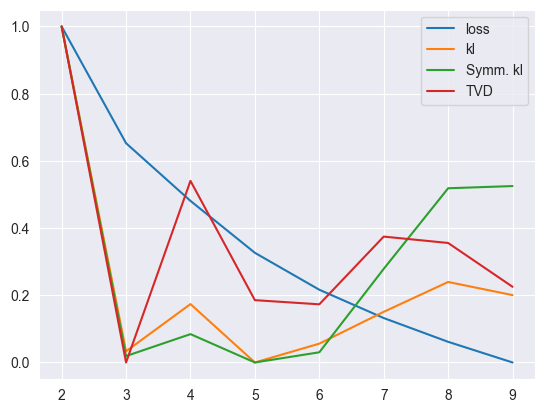

In [43]:
n_last_layer_list = np.arange(2,10)
loss = []
kl = []
kl_symm = []
tvd = []
for n_last_layer in n_last_layer_list:
    with open('params/w_sensitivity/Train_loss_' + str(n_last_layer) + '.npy', 'rb') as f:
        x = pickle.load(f)
    loss.append(np.mean(x))

    with open('params/w_sensitivity/kl_' + str(n_last_layer) + '.npy', 'rb') as f:
        x = pickle.load(f)
    kl.append(x)

    with open('params/w_sensitivity/kl_symm_' + str(n_last_layer) + '.npy', 'rb') as f:
        x = pickle.load(f)
    kl_symm.append(x)

    with open('params/w_sensitivity/tvd_' + str(n_last_layer) + '.npy', 'rb') as f:
        x = pickle.load(f)
    tvd.append(x)

def normalize(x):
    x = x - np.min(x)
    return x/np.max(x)

plt.plot(n_last_layer_list, normalize(loss), label='loss')
plt.plot(n_last_layer_list, normalize(kl), label='kl')
plt.plot(n_last_layer_list, normalize(kl_symm), label='Symm. kl')
plt.plot(n_last_layer_list, normalize(tvd), label='TVD')
plt.legend()

np.savetxt('tikz/fig_w_sensitivity_data/kl_symm.csv', np.vstack([n_last_layer_list, normalize(kl_symm)]).T)
np.savetxt('tikz/fig_w_sensitivity_data/kl.csv', np.vstack([n_last_layer_list,      normalize(kl)]).T)
np.savetxt('tikz/fig_w_sensitivity_data/tvd.csv', np.vstack([n_last_layer_list,     normalize(tvd)]).T)
np.savetxt('tikz/fig_w_sensitivity_data/loss.csv', np.vstack([n_last_layer_list,    normalize(loss)]).T)

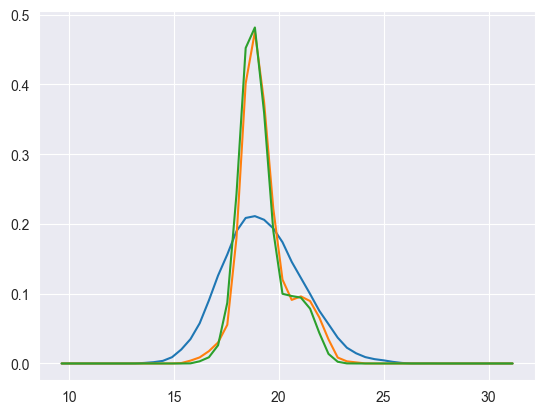

In [42]:
# plot stress for 5 and 9
with open('params/w_sensitivity/data_stat.npy', 'rb') as f:
    stat = pickle.load(f)
with open('params/w_sensitivity/model_stat_5.npy', 'rb') as f:
    model_stat_5 = pickle.load(f)
with open('params/w_sensitivity/model_stat_9.npy', 'rb') as f:
    model_stat_9 = pickle.load(f)

data_kde = gaussian_kde(stat)
xmin = np.min(stat)
xmax = np.max(stat)
r = xmax-xmin
x = np.linspace(xmin - 0.3*r, xmax + 0.3*r)
qk = data_kde(x)


model_kde_5 = gaussian_kde(model_stat_5)
pk_5 = model_kde_5(x)

model_kde_9 = gaussian_kde(model_stat_9)
pk_9 = model_kde_9(x)

plt.plot(x, qk)
plt.plot(x, pk_5)
plt.plot(x, pk_9)